# Reproduction
The following notebook aims at reproducing the __empirical results__ from the paper "[Feature learning in neural networks and kernel machines that recursively learn features](https://arxiv.org/abs/2212.13881)". The experiments aim at showing that RFMs are able to learn extremely similar features to those learned by neural networks. The reproduction focuses on 3 experiments:
1. [__Key result__](#sec1): RFMs and neural networks learn similar features
2. [__Tabular data__](#sec2): RFMs outperforms most models on tabular data
3. [__Special phenomena__](#sec3): Neural networks and RFMs exhibit [grokking](#sec3a) and [simplicity bias](#sec3b)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

plt.ion()

from IPython.display import Markdown

from methods import rfm, nn, xgb, gbt, rf
from utils.misc import suppress_stdout
from utils.visualize import visualize_M_dict, visualize_curves_dict
from utils.data import split


SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)

/home/ggalletti/git/recursive_feature_machines_praktikum/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Key result: RFMs and neural networks learn similar features
The original paper shows that RFMs and neural networks learn similar features on the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. The following code focuses on that, as it's the main empirical results that motivates the usefulness of RFMs in the study of neural networks.
<a id='sec1'></a>

In [2]:
from torchvision.datasets import CelebA

CELEBA_SIZE = 24

with suppress_stdout():
    dataset_path = os.path.join(os.getcwd(), "datasets")
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    celeba_transform = transforms.Compose(
        [transforms.Resize([CELEBA_SIZE, CELEBA_SIZE]), transforms.ToTensor()]
    )
    celeba_trainset_full = CelebA(
        root=dataset_path, split="train", transform=celeba_transform, download=True
    )
    celeba_testset_full = CelebA(
        root=dataset_path, split="test", transform=celeba_transform, download=True
    )

### Training on __attractive__

#### Train size 39416, val size 9854

| Metric | RFM | MLP |
| --- | --- | --- |
| Params | NA | 573952 |
| Time | 219.33s | 268.47s |
| Accuracy | 75.26% | 75.82% |
| MSE | 0.17 | 0.17 |


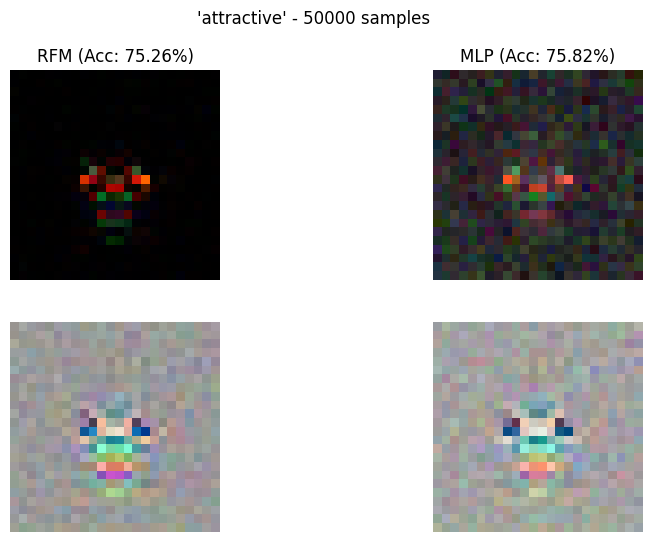

---

### Training on __young__

#### Train size 28765, val size 7192

| Metric | RFM | MLP |
| --- | --- | --- |
| Params | NA | 573952 |
| Time | 116.57s | 217.64s |
| Accuracy | 81.69% | 81.16% |
| MSE | 0.14 | 0.14 |


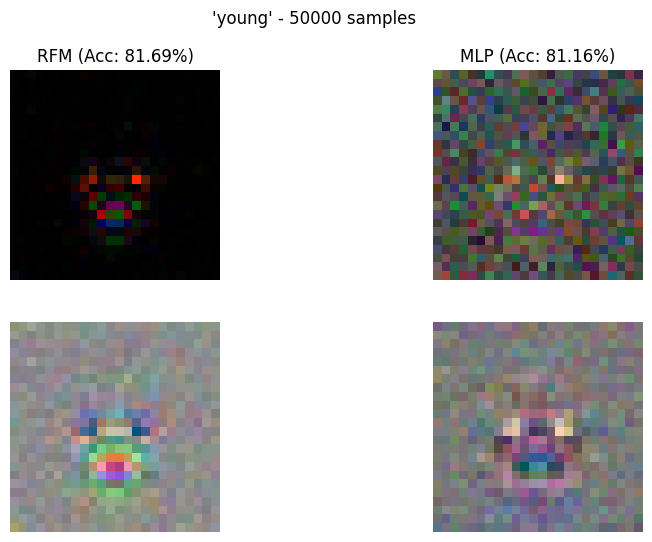

---

In [5]:
from utils.data import get_celeba_balanced_data

# number of celebA training samples
CELEBA_N_REGIMES = [50000]
CELEBA_TARGETS = ["attractive", "young"]

for key in CELEBA_TARGETS:
    display(Markdown(f"### Training on __{key}__"))

    for n_train in CELEBA_N_REGIMES:
        n_test = n_train // 5

        celeba_trainset = get_celeba_balanced_data(
            celeba_trainset_full, num_samples=n_train, target=key
        )
        celeba_trainset, valset = split(celeba_trainset, p=0.8)

        display(
            Markdown(f"#### Train size {len(celeba_trainset)}, val size {len(valset)}")
        )

        trainloader = torch.utils.data.DataLoader(
            celeba_trainset, batch_size=128, shuffle=True, num_workers=2
        )

        valloader = torch.utils.data.DataLoader(
            valset, batch_size=100, shuffle=False, num_workers=1
        )

        celeba_testset = get_celeba_balanced_data(
            celeba_testset_full, num_samples=n_test, target=key
        )

        testloader = torch.utils.data.DataLoader(
            celeba_testset, batch_size=512, shuffle=False, num_workers=1
        )

        start = time.perf_counter_ns()
        M_rfm, mse_rfm, acc_rfm, _ = rfm.train(trainloader, testloader, iters=1)
        time_rfm = (time.perf_counter_ns() - start) / 1e9

        start = time.perf_counter_ns()
        mlp, mse_mlp, acc_mlp, _ = nn.train(trainloader, valloader, testloader)
        time_mlp = (time.perf_counter_ns() - start) / 1e9
        n_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)

        table = f"| Metric | RFM | MLP |\n| --- | --- | --- |\n"
        table += f"| Params | NA | {n_params} |\n"
        table += f"| Time | {time_rfm:.2f}s | {time_mlp:.2f}s |\n"
        table += f"| Accuracy | {acc_rfm:.2f}% | {acc_mlp:.2f}% |\n"
        table += f"| MSE | {mse_rfm:.2f} | {mse_mlp:.2f} |\n"

        display(Markdown(table))

        F_dict, _ = visualize_M_dict(
            {f"RFM": (acc_rfm, M_rfm), f"MLP": (acc_mlp, mlp.M)},
            title=f"'{key}' - {n_train} samples",
        )
        plt.show()

    display(Markdown("---"))

## 2. Tabular data: RFMs outperforms most models on tabular data
Reportedly RFMs get better accuracy on tabular benchmark datasets than other models, such as XGBoost and MLPs. This sections reproduces those results on a couple of benchmarks.

All the datasets used are subsamples of the original benchmarking datasets. Abeit better than neural networks, RFMs do not beat tree-based models on tabular data.
<a id='sec2'></a>

In [2]:
from utils.data import get_tabular_datasets

N_SAMPLES_TABULAR = 10000

TABULAR_DATASETS = [
    "electricity",
    "telescope",
    "miniboone",
    "higgs",
    "jannis",
    "covertype",
]

table_dataset_dict = get_tabular_datasets(
    TABULAR_DATASETS, max_samples=N_SAMPLES_TABULAR
)

table_dataset_dict["electricity 10K"] = table_dataset_dict["electricity"]
del table_dataset_dict["electricity"]
electricity_full = get_tabular_datasets(["electricity"])["electricity"]
table_dataset_dict["electricity Full"] = electricity_full

In [3]:
result_dict = {}

for name, data in table_dataset_dict.items():
    for i in range(3):
        table_train_data, table_evaluation_data = split(data, p=0.8)
        table_val_data, table_test_data = split(table_evaluation_data, p=0.1)

        if i == 0:
            display(
                Markdown(
                    f"Training on '__{name}__'\n"
                    f"Train size: {len(table_train_data)}, "
                    f"eval size: {len(table_val_data)} + {len(table_test_data)}"
                )
            )

        table_trainloader = torch.utils.data.DataLoader(
            table_train_data, batch_size=1024, shuffle=True, num_workers=2
        )
        table_valloader = torch.utils.data.DataLoader(
            table_val_data, batch_size=100, shuffle=False, num_workers=1
        )
        table_testloader = torch.utils.data.DataLoader(
            table_test_data, batch_size=512, shuffle=False, num_workers=1
        )

        _, _, acc_rfm, _ = rfm.train(table_trainloader, table_testloader, iters=2)
        _, _, acc_mlp, _ = nn.train(
            table_trainloader, table_valloader, table_testloader, lr=1e-2, num_layers=6
        )
        # xgboost
        _, acc_xgb = xgb.train(table_train_data, table_test_data)

        # tree based
        _, acc_gbt = gbt.train(table_train_data, table_test_data)
        _, acc_rf = rf.train(table_train_data, table_test_data)

        if name not in result_dict:
            result_dict[name] = {
                "RFM": [acc_rfm],
                "MLP": [acc_mlp],
                "XGB": [acc_xgb],
                "GBT": [acc_gbt],
                "RF": [acc_rf],
            }
        else:
            result_dict[name]["RFM"].append(acc_rfm)
            result_dict[name]["MLP"].append(acc_mlp)
            result_dict[name]["XGB"].append(acc_xgb)
            result_dict[name]["GBT"].append(acc_gbt)
            result_dict[name]["RF"].append(acc_rf)

for name in result_dict:
    result_dict[name] = {
        "RFM": np.array(result_dict[name]["RFM"]),
        "MLP": np.array(result_dict[name]["MLP"]),
        "XGB": np.array(result_dict[name]["XGB"]),
        "GBT": np.array(result_dict[name]["GBT"]),
        "RF": np.array(result_dict[name]["RF"]),
    }

result_table = (
    f"| Dataset | RFM | MLP | XGB | GBT | RF |\n| --- | --- | --- | --- | --- | --- |\n"
)
for name, results in result_dict.items():
    result_table += (
        f"| {name} | "
        f"{results['RFM'][1]:.2f}% $\pm$ {3 * results['RFM'].std():.2f}% |"
        f"{results['MLP'].mean():.2f}% $\pm$ {3 * results['MLP'].std():.2f}% |"
        f"{results['XGB'].mean():.2f}% $\pm$ {3 * results['XGB'].std():.2f}% |"
        f"{results['GBT'].mean():.2f}% $\pm$ {3 * results['GBT'].std():.2f}% | "
        f"{results['RF'].mean():.2f}% $\pm$ {3 * results['RF'].std():.2f}% |\n"
    )

display(Markdown(result_table))

display(Markdown("---"))

Training on '__telescope__'
Train size: 5350, eval size: 133 + 1205

Training on '__miniboone__'
Train size: 8000, eval size: 200 + 1800

Training on '__higgs__'
Train size: 8000, eval size: 200 + 1800

Training on '__jannis__'
Train size: 8000, eval size: 200 + 1800

Training on '__covertype__'
Train size: 8000, eval size: 200 + 1800

Training on '__electricity 10K__'
Train size: 8000, eval size: 200 + 1800

Training on '__electricity Full__'
Train size: 30779, eval size: 769 + 6926

| Dataset | RFM | MLP | XGB | GBT | RF |
| --- | --- | --- | --- | --- | --- |
| telescope | 100.00% $\pm$ 0.00% |49.79% $\pm$ 5.01% |100.00% $\pm$ 0.00% |100.00% $\pm$ 0.00% | 100.00% $\pm$ 0.00% |
| miniboone | 88.17% $\pm$ 0.55% |50.26% $\pm$ 1.59% |93.59% $\pm$ 0.97% |90.04% $\pm$ 1.38% | 88.11% $\pm$ 0.47% |
| higgs | 65.67% $\pm$ 1.46% |59.72% $\pm$ 1.84% |69.33% $\pm$ 0.24% |66.11% $\pm$ 1.52% | 67.11% $\pm$ 2.59% |
| jannis | 68.06% $\pm$ 2.18% |49.19% $\pm$ 2.99% |76.44% $\pm$ 1.57% |72.83% $\pm$ 1.91% | 71.37% $\pm$ 4.40% |
| covertype | 86.78% $\pm$ 0.86% |80.39% $\pm$ 3.97% |85.11% $\pm$ 1.66% |81.87% $\pm$ 2.21% | 79.74% $\pm$ 2.13% |
| electricity 10K | 92.72% $\pm$ 2.39% |87.69% $\pm$ 0.86% |96.94% $\pm$ 0.59% |96.57% $\pm$ 0.28% | 93.46% $\pm$ 0.28% |
| electricity Full | 83.70% $\pm$ 0.54% |74.29% $\pm$ 0.94% |89.72% $\pm$ 0.59% |87.38% $\pm$ 0.87% | 74.37% $\pm$ 0.51% |


---

## 3. Special phenomena: Neural networks and RFMs exhibit grokking and simplicity bias
Finally, it is shown that RFMs exhibit [grokking](#sec3a) and [simplicity bias](#sec3b), as neural networks do. This last section reproduces the results for RFMs and neural networks on grokking and simplicity bias.

<a id='sec3'></a>

 ### Grokking
 Grokking is a dramatic increase in test accuracy when training past the point of overfitting. Arguably, it happens when the model learns a latent algorithm to solve the task (e.g. if the data is algorighmically generated).
 
 The following code reproduces the results for RFMs and neural networks on the STL10 (planes and trucks) dataset. The experiment consists of training two models, one on the clean dataset and one on a modified version of the dataset that contains a easy to learn class tip (cross on the top right).

Grokking was very hard to create, even in MLPs. From this setup, RFMs do not seem to exhibit grokking because they immediately pick up the grokking tip.

 <a id='sec3a'></a>

In [3]:
from torchvision.datasets import STL10

from utils.data import get_stl10_data
from utils.preprocess import add_grok_tip

# number of STL10 training samples
GROKKING_STL10_TARGETS = [0, 9]
STL10_SIZE = 96 // 2

with suppress_stdout():
    dataset_path = os.path.join(os.getcwd(), "datasets")
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    stl10_transform = transforms.Compose(
        [transforms.Resize([STL10_SIZE, STL10_SIZE]), transforms.ToTensor()]
    )
    stl10_trainset_full = STL10(
        root=dataset_path, split="train", transform=stl10_transform, download=True
    )
    stl10_testset_full = STL10(
        root=dataset_path, split="test", transform=stl10_transform, download=True
    )

stl10_trainset = get_stl10_data(
    stl10_trainset_full, GROKKING_STL10_TARGETS, class_ratio=0.95
)
stl10_testset = get_stl10_data(
    stl10_testset_full, GROKKING_STL10_TARGETS, class_ratio=0.5
)

# add grokking tip
stl10_trainset_grok = add_grok_tip(stl10_trainset)
stl10_trainset_grok, stl10_valset_grok = split(stl10_trainset_grok, p=0.3)
stl10_testset_grok = add_grok_tip(stl10_testset)

train_trucks = sum(1 if l[1] == 1 else 0 for _, l in stl10_trainset)
train_planes = sum(1 if l[0] == 1 else 0 for _, l in stl10_trainset)
display(Markdown(f"Training: {train_planes} planes and {train_trucks} trucks"))
test_trucks = sum(1 if l[1] == 1 else 0 for _, l in stl10_testset)
test_planes = sum(1 if l[0] == 1 else 0 for _, l in stl10_testset)
display(Markdown(f"Test: {test_planes} planes and {test_trucks} trucks"))

Training: 500 planes and 51 trucks

Test: 800 planes and 800 trucks

### Grokking STL10 __[0, 9]__

Train size: 551, eval size: 1600

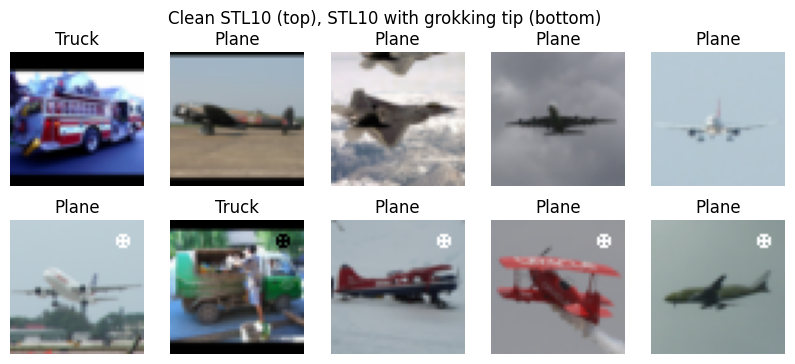

In [13]:
display(Markdown(f"### Grokking STL10 __{GROKKING_STL10_TARGETS}__"))

display(
    Markdown(f"Train size: {len(stl10_trainset)}, " f"eval size: {len(stl10_testset)}")
)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("Clean STL10 (top), STL10 with grokking tip (bottom)")
for i, (img, label) in enumerate(stl10_trainset[:5]):
    axs[0, i].imshow(img.reshape(3, STL10_SIZE, STL10_SIZE).permute(1, 2, 0))
    axs[0, i].set_title(["Plane", "Truck"][label.argmax()])
    axs[0, i].axis("off")
for i, (img, label) in enumerate(stl10_trainset_grok[:5]):
    axs[1, i].imshow(img.reshape(3, STL10_SIZE, STL10_SIZE).permute(1, 2, 0))
    axs[1, i].set_title(["Plane", "Truck"][label.argmax()])
    axs[1, i].axis("off")
plt.show()

#### Without grokking

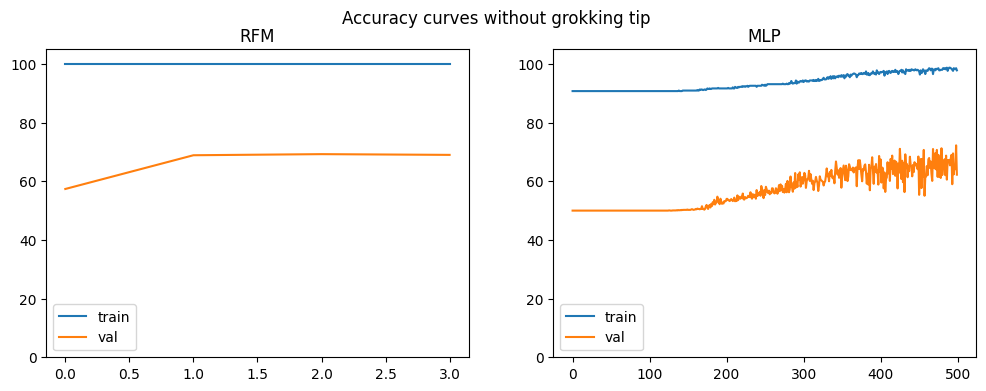

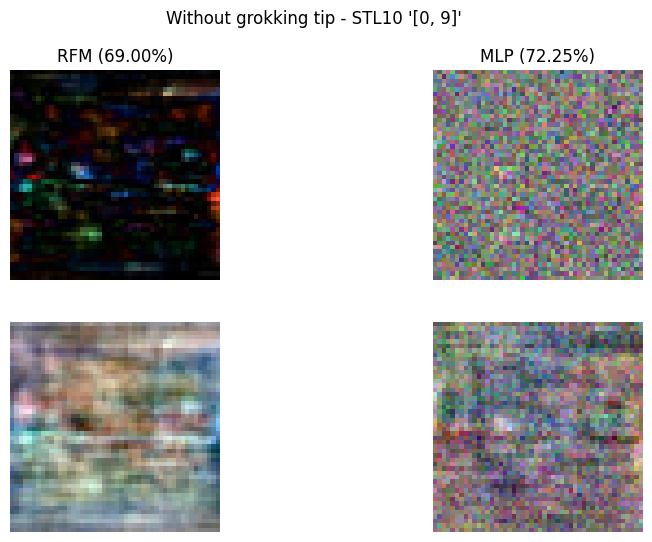

---

In [12]:
trainloader = torch.utils.data.DataLoader(
    stl10_trainset, batch_size=124, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    stl10_testset, batch_size=512, shuffle=False, num_workers=1
)

display(Markdown("#### Without grokking"))

M_rfm, mse_rfm, acc_rfm, accs_rfm = rfm.train(
    trainloader, testloader, iters=4, reg=1e-3
)
mlp, mse_mlp, acc_mlp, accs_mlp = nn.train(
    trainloader,
    testloader,
    testloader,
    width=128,
    num_epochs=500,
    lr=1e-2,
    grok_init=False,
)

visualize_curves_dict(
    {"RFM": accs_rfm, "MLP": accs_mlp}, title="Accuracy curves without grokking tip"
)
visualize_M_dict(
    {"RFM": (acc_rfm, M_rfm), "MLP": (acc_mlp, mlp.M)},
    title=f"Without grokking tip - STL10 '{GROKKING_STL10_TARGETS}'",
)

plt.show()

display(Markdown("---"))

#### With grokking

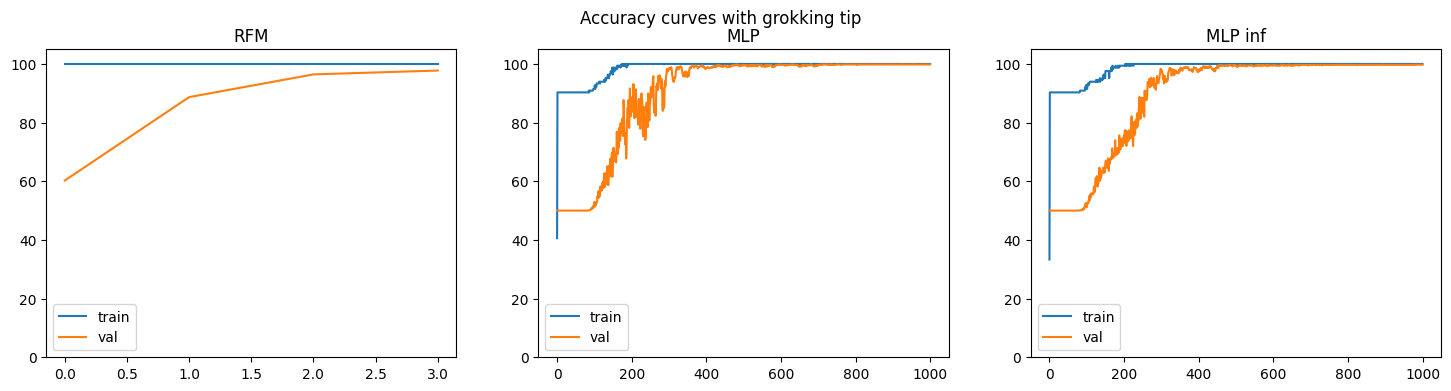

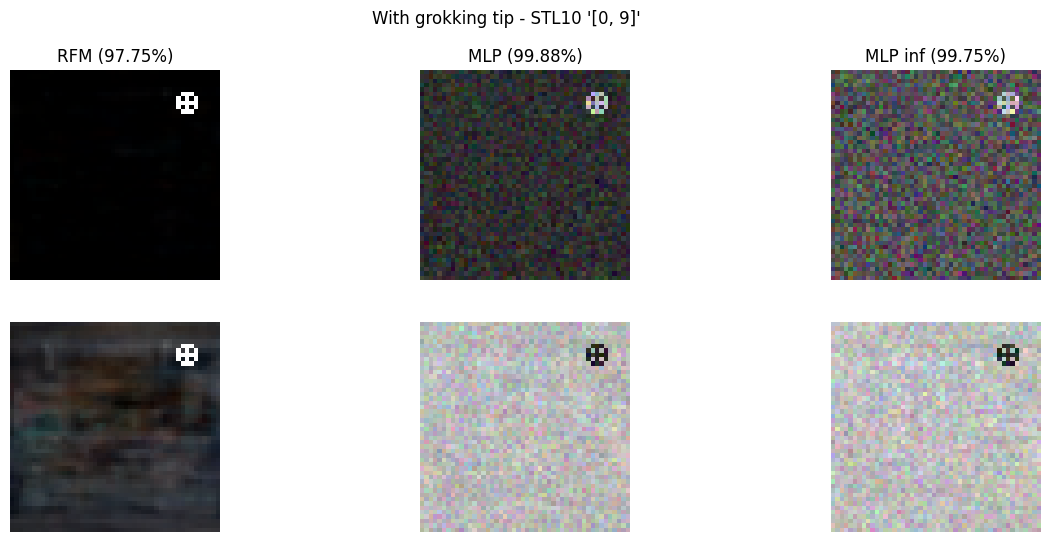

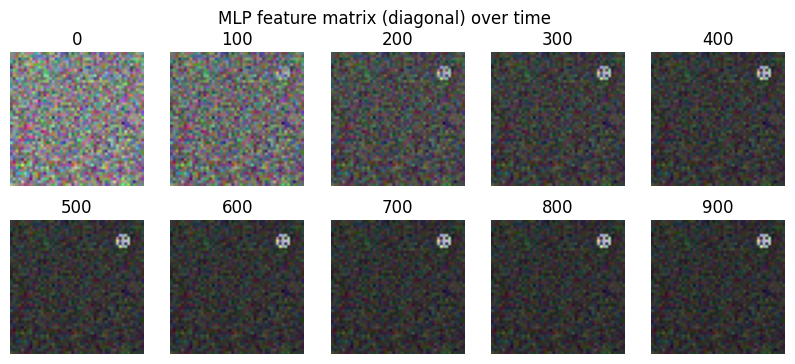

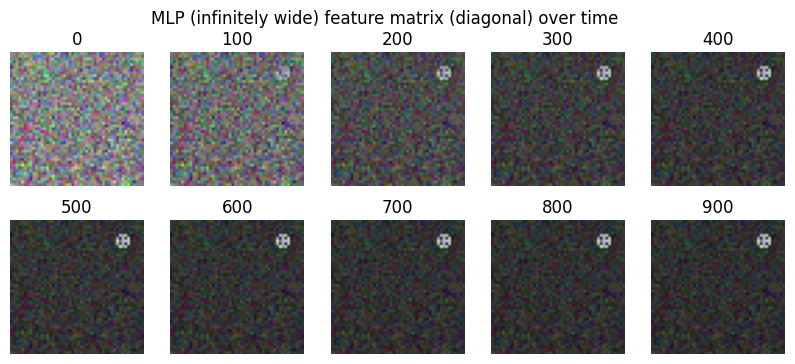

---

In [13]:
trainloader_grok = torch.utils.data.DataLoader(
    stl10_trainset_grok, batch_size=124, shuffle=True, num_workers=2
)
testloader_grok = torch.utils.data.DataLoader(
    stl10_testset_grok, batch_size=512, shuffle=False, num_workers=1
)

display(Markdown("#### With grokking"))
M_rfm, mse_rfm, acc_rfm, accs_rfm = rfm.train(
    trainloader_grok, testloader_grok, iters=4, reg=1e-3
)

mlp_grok, mse_mlp, acc_mlp, accs_mlp, frames = nn.train(
    trainloader_grok,
    testloader_grok,
    testloader_grok,
    width=128,
    num_epochs=1000,
    lr=1e-2,
    frame_freq=100,
    grok_init=False,
)

mlp_grok2, mse_mlp2, acc_mlp2, accs_mlp2, frames2 = nn.train(
    trainloader_grok,
    testloader_grok,
    testloader_grok,
    width=len(stl10_trainset) + 1,
    num_epochs=1000,
    lr=1e-2,
    frame_freq=100,
    grok_init=False,
)

visualize_curves_dict(
    {"RFM": accs_rfm, "MLP": accs_mlp, "MLP inf": accs_mlp2},
    title="Accuracy curves with grokking tip",
)
visualize_M_dict(
    {
        "RFM": (acc_rfm, M_rfm),
        "MLP": (acc_mlp, mlp_grok.M),
        "MLP inf": (acc_mlp2, mlp_grok2.M),
    },
    title=f"With grokking tip - STL10 '{GROKKING_STL10_TARGETS}'",
)
plt.show()

# visualize frames as images (list of arrays)
fig, axs = plt.subplots(2, len(frames) // 2, figsize=(len(frames), 4))
fig.suptitle("MLP feature matrix (diagonal) over time")
for i, (it, frame) in enumerate(frames.items()):
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].imshow(frame)
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].axis("off")
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].set_title(it)
plt.show()

# visualize frames as images (list of arrays)
fig, axs = plt.subplots(2, len(frames) // 2, figsize=(len(frames), 4))
fig.suptitle("MLP (infinitely wide) feature matrix (diagonal) over time")
for i, (it, frame) in enumerate(frames.items()):
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].imshow(frame)
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].axis("off")
    axs[int(i >= axs.shape[1]), i % axs.shape[1]].set_title(it)
plt.show()

display(Markdown("---"))

### Simplicity bias
Networks rely on simpler features to solve the task, even if more complex features are available. This could happen because neural networks tend to be as linear as possible. This phenomenon is called simplicity bias. It is tested by concatenating two datasets, where one is considered "harder" than the other. If the network tends to learn only the features of the easier dataset, then it is said to exhibit simplicity bias.

In the following example STL10 (trucks and planes) and MNIST (digits) are considered. The former is considered harder than the latter. The "simplicity" dataset is produced by concatenating "9" digits to the "truck" class samples, and "0" digits to the "plane" class samples.
Both RFMs and MLPs exhibit simplicity bias, as they tend to learn only the features of the easier dataset (MNIST). The reproduced result matches the original paper.

<a id='sec3b'></a>

In [15]:
from torchvision.datasets import MNIST, STL10

from utils.data import get_stl10_data
from utils.preprocess import concatenate_datasets

# number of STL10 training samples
SIMP_N_TRAIN = 1000
SIMP_TARGETS = [0, 9]

with suppress_stdout():
    dataset_path = os.path.join(os.getcwd(), "datasets")
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    mnist_transform = transforms.Compose([transforms.ToTensor()])
    mnist_trainset_full = MNIST(
        dataset_path, train=True, transform=mnist_transform, download=True
    )
    mnist_testset_full = MNIST(
        dataset_path, train=False, transform=mnist_transform, download=True
    )
    # MNIST images are (28, 28), match shape for concatenation
    stl10_transform = transforms.Compose(
        [transforms.Resize([28, 28]), transforms.Grayscale(), transforms.ToTensor()]
    )
    stl10_trainset_full_simp = STL10(
        root=dataset_path, split="train", transform=stl10_transform, download=True
    )
    stl10_testset_full_simp = STL10(
        root=dataset_path, split="test", transform=stl10_transform, download=True
    )

    stl10_trainset = get_stl10_data(
        stl10_trainset_full_simp,
        num_samples=SIMP_N_TRAIN,
        targets=SIMP_TARGETS,
    )
    simp_trainset = concatenate_datasets(
        stl10_trainset, mnist_trainset_full, SIMP_TARGETS
    )

    simp_trainset, simp_valset = split(simp_trainset, p=0.5)

    stl10_testset = get_stl10_data(
        stl10_testset_full_simp,
        num_samples=SIMP_N_TRAIN,
        targets=SIMP_TARGETS,
    )
    simp_testset = concatenate_datasets(stl10_testset, mnist_testset_full, SIMP_TARGETS)

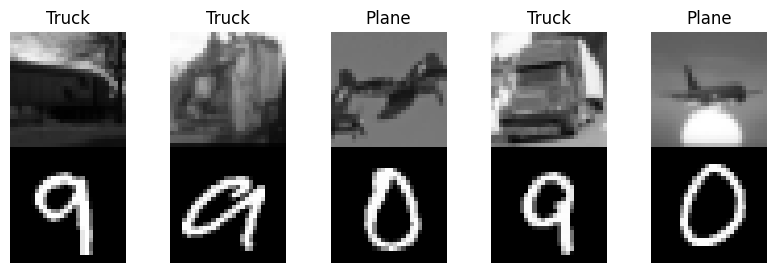

In [19]:
# visualize the first 5 images in simp_trainset
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, (img, label) in enumerate(simp_trainset[8:13]):
    axs[i].imshow(img.reshape(2 * 28, 28), cmap="gray")
    axs[i].set_title(["Plane", "Truck"][label.argmax()])
    axs[i].axis("off")
plt.show()

### Simplicity bias STL10 + MNIST __[0, 9]__

Train size: 97, eval size: 98

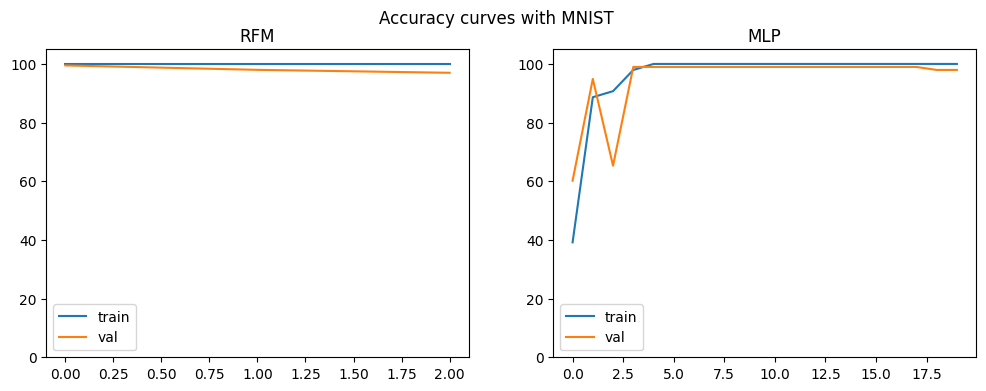

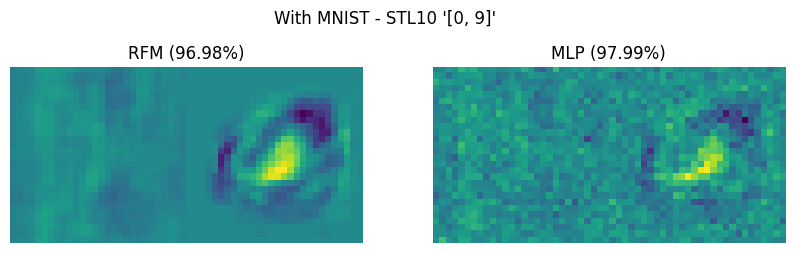

---

In [11]:
display(Markdown(f"### Simplicity bias STL10 + MNIST __{SIMP_TARGETS}__"))

display(Markdown(f"Train size: {len(simp_trainset)}, eval size: {len(simp_valset)}"))

simp_trainloader = torch.utils.data.DataLoader(
    simp_trainset, batch_size=1024, shuffle=True, num_workers=2
)
simp_valloader = torch.utils.data.DataLoader(
    simp_valset, batch_size=100, shuffle=False, num_workers=1
)
simp_testloader = torch.utils.data.DataLoader(
    simp_testset, batch_size=512, shuffle=False, num_workers=1
)

M_rfm, mse_rfm, acc_rfm, accs_rfm = rfm.train(simp_trainloader, simp_testloader)
mlp, mse_mlp, acc_mlp, accs_mlp = nn.train(
    simp_trainloader, simp_valloader, simp_testloader
)

visualize_curves_dict(
    {"RFM": accs_rfm, "MLP": accs_mlp}, title="Accuracy curves with MNIST"
)

visualize_M_dict(
    {"RFM": (acc_rfm, M_rfm), "MLP": (acc_mlp, mlp.M)},
    title=f"With MNIST - STL10 '{SIMP_TARGETS}'",
    target_plots=["eig"],
    shape=(2 * 28, 28),
)
plt.show()

display(Markdown("---"))

## Future extensions
### Where are features learned in neural networks?
- Swap feature matrices between neural networks and RFMs
- Somehow force every MLP layer to learn features
- RFM with hypernetwork for the feature matrix

### Higher order optimization (for neural networks)
- What happens to the gradient outer product?
- Does it have the same result on learned features?

### Feature learning with structural constraints
- What happens if we add structural constraints to the feature matrix? e.g. CNNs
